In [0]:
import pandas as pd
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date
from pyspark.sql.types import StringType, FloatType, DateType
import matplotlib.pyplot as plt
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-e2f8c9a4-e4b1-4abf-9c8d-967d39f1ed87/bin/python -m pip install --upgrade pip' command.


**Creazione della Spark Session**

In [0]:
spark = SparkSession.builder.appName("BitcoinSentimentAnalysis").getOrCreate()

**Caricamento del dataset**

In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv -O bitcoin_tweets.csv

--2024-08-30 12:40:49--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 16.12.18.38, 52.95.155.36
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|16.12.18.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv’

bitcoin_tweets.csv  100%[===================>]  23.56M  8.27MB/s    in 2.8s    

2024-08-30 12:40:53 (8.27 MB/s) - ‘bitcoin_tweets.csv’ saved [24708828/24708828]



In [0]:
dataset = pd.read_csv('bitcoin_tweets.csv', delimiter=",")


**Conversione del DataFrame di pandas in DataFrame di Spark**

In [0]:
spark_df = spark.createDataFrame(dataset)

In [0]:
spark_df.write.format("parquet").mode("overwrite").saveAsTable("bitcoin_sentiment_analysis")

**Pulizia dei tweet (rimozione link, menzioni, hashtag, caratteri speciali e conversione del testo in minuscolo)**

In [0]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'@\w+', '', tweet)   
    tweet = re.sub(r'#', '', tweet)       
    tweet = re.sub(r'[^A-Za-z0-9 ]+', '', tweet)  
    return tweet.lower() 

**Funzione UDF per pulire i tweet**

In [0]:
clean_tweet_udf = udf(clean_tweet, StringType())

In [0]:
df = spark.sql("SELECT * FROM bitcoin_sentiment_analysis")

**Applicazione della funzione per la pulizia**

In [0]:
df = df.withColumn('clean_text', clean_tweet_udf(col('text')))
df = df.withColumn('date', to_date(col('timestamp'), 'yyyy-MM-dd'))


**Creazione dell'oggetto SentimentIntensityAnalyzer**

In [0]:
analyzer = SentimentIntensityAnalyzer()

**Creazione di una funzione per il calcolo del punteggio di sentimenti**

In [0]:
def get_sentiment_score(tweet):
    return float(analyzer.polarity_scores(tweet)['compound'])

**Funzione UDF per ottenere il punteggio di sentiment**

In [0]:
get_sentiment_score_udf = udf(get_sentiment_score, FloatType())


**Calcolo del punteggio del sentiment**

In [0]:
df = df.withColumn('sentiment_score', get_sentiment_score_udf(col('clean_text')))

**Funzione per la classificazione del sentiment**

In [0]:
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

**Funzione UDF per classificare il sentiment**

In [0]:
classify_sentiment_udf = udf(classify_sentiment, StringType())

In [0]:
df = df.withColumn('sentiment', classify_sentiment_udf(col('sentiment_score')))


**Analisi dei likes e delle risposte per sentiment**

In [0]:
likes_analysis = df.groupBy('sentiment').avg('likes').collect()
replies_analysis = df.groupBy('sentiment').avg('replies').collect()
print("Media dei likes per sentiment:")
for row in likes_analysis:
    print(f"{row['sentiment']}: {row['avg(likes)']}")

print("Media delle risposte per sentiment:")
for row in replies_analysis:
    print(f"{row['sentiment']}: {row['avg(replies)']}")

Media dei likes per sentiment:
positive: 9.268682207706599
neutral: 4.94231652429503
negative: 11.694061679790027
Media delle risposte per sentiment:
positive: 1.312548690597471
neutral: 0.46097180123082576
negative: 1.2028379265091864


In [0]:
likes_data = {row['sentiment']: row['avg(likes)'] for row in likes_analysis}
replies_data = {row['sentiment']: row['avg(replies)'] for row in replies_analysis}

**Visualizzazione della media dei likes per sentiment**

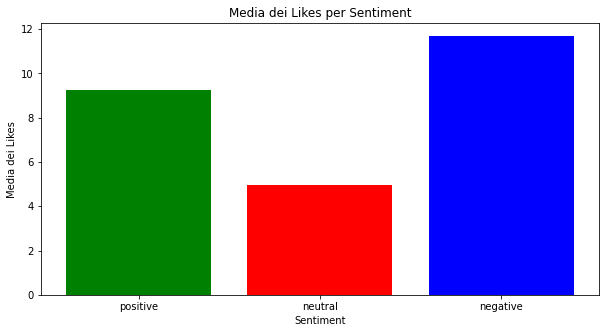

In [0]:
plt.figure(figsize=(10, 5))
plt.bar(likes_data.keys(), likes_data.values(), color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Media dei Likes')
plt.title('Media dei Likes per Sentiment')
plt.show()

Positive: La media dei likes per i tweet con sentiment positivo è leggermente più bassa rispetto alla media dei likes negativi

Negative: I tweet con sentiment negativo hanno ricevuto una media di likes superiore rispetto a quelli positivi.

Neutral: I tweet con sentiment neutro hanno avuto mediamente meno likes rispetto a quelli positivi

**Visualizzazione della media delle risposte per sentiment**

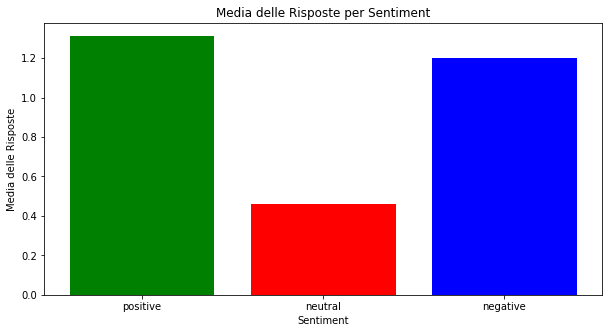

In [0]:
plt.figure(figsize=(10, 5))
plt.bar(replies_data.keys(), replies_data.values(), color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Media delle Risposte')
plt.title('Media delle Risposte per Sentiment')
plt.show()

Positive: I tweet con sentiment positivo hanno ricevuto mediamente più risposte rispetto agli altri sentiment.

Negative: I tweet con sentiment negativo hanno avuto un numero di risposte inferiore ai tweet positivi, ma comunque significativo.

Neutral: I tweet neutri hanno avuto mediamente meno risposte rispetto ai tweet positivi e negativi.


**Media dei retweet per sentiment**

In [0]:
retweets_analysis = df.groupBy('sentiment').avg('retweets').collect()
print("Media dei retweet per sentiment:")
for row in retweets_analysis:
    print(f"{row['sentiment']}: {row['avg(retweets)']}")

Media dei retweet per sentiment:
positive: 3.720830586684245
neutral: 2.0153761366767706
negative: 3.104084645669291


**Percentuale di tweet per ciascun sentiment**

In [0]:
total_tweets = df.count()
sentiment_counts = df.groupBy('sentiment').count().collect()
print("Percentuale di tweet per ciascun sentiment:")
for row in sentiment_counts:
    percentage = (row['count'] / total_tweets) * 100
    print(f"{row['sentiment']}: {percentage:.2f}%")

Percentuale di tweet per ciascun sentiment:
positive: 33.37%
neutral: 54.43%
negative: 12.19%


**Visualizzazione della media dei retweet per sentiment**

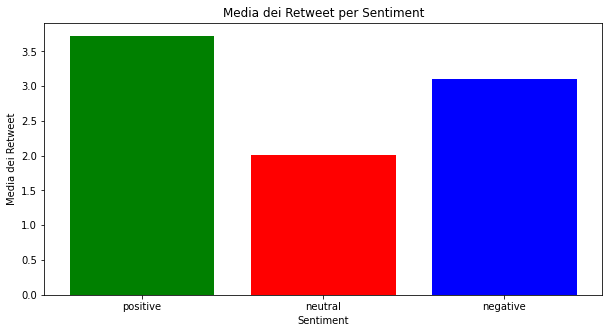

In [0]:
retweets_data = {row['sentiment']: row['avg(retweets)'] for row in retweets_analysis}
plt.figure(figsize=(10, 5))
plt.bar(retweets_data.keys(), retweets_data.values(), color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Media dei Retweet')
plt.title('Media dei Retweet per Sentiment')
plt.show()


Positive: I tweet positivi sono stati retweettati mediamente di più rispetto ai tweet neutri e negativi.

Negative: I tweet negativi hanno avuto una media di retweet inferiore rispetto ai tweet positivi, ma non di molto.

Neutral: I tweet neutri hanno avuto il minor numero di retweet in media.

**Visualizzazione della percentuale di tweet per ciascun sentiment**

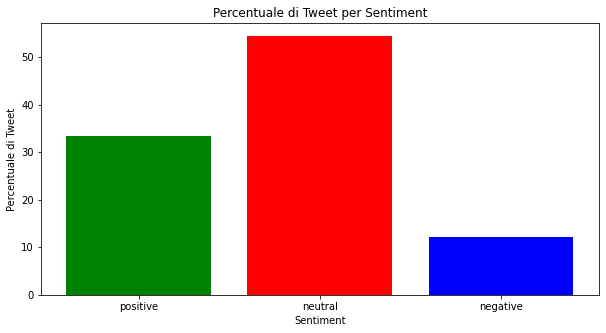

In [0]:
sentiment_percentages = {row['sentiment']: (row['count'] / total_tweets) * 100 for row in sentiment_counts}
plt.figure(figsize=(10, 5))
plt.bar(sentiment_percentages.keys(), sentiment_percentages.values(), color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Percentuale di Tweet')
plt.title('Percentuale di Tweet per Sentiment')
plt.show()

Positive: Una percentuale significativa dei tweet analizzati ha un sentiment positivo, suggerendo un generale ottimismo o atteggiamento favorevole verso il Bitcoin.

Negative: La percentuale di tweet con sentiment negativo è inferiore rispetto a quelli con sentiment positivo e neutro, indicando che le opinioni negative sono meno comuni.

Neutral: Una buona parte dei tweet ha un sentiment neutro, indicando discussioni oggettive o informative riguardo il Bitcoin.

**Conclusioni**

 I tweet con sentiment positivo tendono a generare più interazioni in termini di likes, risposte e retweet rispetto ai tweet negativi e neutri. Questo potrebbe indicare che gli utenti di Twitter sono più inclini a interagire con contenuti che presentano il Bitcoin in una luce positiva.
Inoltre, la predominanza di sentiment positivo e neutro suggerisce che la comunità di Twitter ha generalmente una visione favorevole o neutrale del Bitcoin. Le opinioni negative, sebbene presenti, sono meno comuni.

